# generate grid maps

In [11]:
from os import path
import sys
sys.path.append('..')
from radar_scenes.sequence import Sequence
from numpy import stack, float32, array, zeros, sum, ndarray, linspace
from matplotlib.pyplot import imshow, colorbar, title, grid
import matplotlib.patches as pc
from pytorchyolo.models import load_model

from snippet import clip
import torch
from matplotlib import pyplot as plt
from yolo.detect import detect_image
from yolo.preprocessing.boxes import get_AABB_snippet
from frame import get_timestamps, get_frames
from yolo.preprocessing.gridMap import GridMap
from yolo.preprocessing.coordinateTransfer import coor_transfer
from yolo.preprocessing.boxes import visualize_AABB_cloud

In [12]:
LABEL_NUM = { 0:'CAR',
    1:'PEDESTRIAN',
    2:'PEDESTRIAN_GROUP', 
    3:'TWO_WHEELER',
    4:'LARGE_VEHICLE', 
    5:'STATIC'}
COLOR_SCHEME = { 'CAR':  '#FF6347',
    'PEDESTRIAN': '#4B0082',
    'PEDESTRIAN_GROUP': '#FFD700', 
    'TWO_WHEELER': '#8FBC8F',
    'LARGE_VEHICLE': '#008B8B', 
    'STATIC': '#9400D3'}
GND_LINE = '-'
DET_LINE = '--'

def reverse_transfer(boxes):
    '''
    transfer boxes's coordinate from image coordinate  to ego-vehicle coordinate
    and also in yolo format, i.e., ratio
    param: boxes: n*5 ndarray, [x, y, w, h, class]
    return: tran_boxes: transferred boxes in image coordinate
    '''
    # frame size
    LENGTH = 100
    # print(boxes.shape)
    tran_boxes = zeros((boxes.shape[0], boxes.shape[1]))
    # print(tran_boxes.shape)
    tran_boxes[:, 0] = boxes[:, 4] 
    tran_boxes[:, 1] = 100 - 50 * (boxes[:, 1]+boxes[:, 3]) / 608
    tran_boxes[:, 2] = - 50*(boxes[:, 0]+boxes[:, 2])/608+50
    tran_boxes[:, 3] = 100 * abs(boxes[:, 1]-boxes[:, 3]) / 608
    tran_boxes[:, 4] = 100 * abs(boxes[:, 2]-boxes[:, 0]) / 608
    return tran_boxes


def visualize_AABB_cloud(points: ndarray, truth, detection)->None:
    '''
    Visualize the ground truth and detections on ego-vehicle coordinate
    param truth: 
    '''
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(1, 1, 1)
    col = [0, 0, 0, 1]
    #plot point cloud
    ax.plot(
        points[1, :], #y_cc
        points[0, :], #x_cc
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="#A9A9A9",
        markersize=1
    )
        # plot AABB
    for box in truth:
        c, center_x, center_y, w, h = box # w is always on x axis
        color = COLOR_SCHEME[LABEL_NUM[c]] 
        bottom_left_horizon = center_y - h/2
        bottom_left_vertical = center_x - w/2
        rect = pc.Rectangle((bottom_left_horizon, bottom_left_vertical), h, w,
                            angle=0, fill=False, edgecolor = color,linewidth=1,
                            linestyle=GND_LINE, label='{}'.format('GND '+LABEL_NUM[c]))
        ax.add_patch(rect)
    
    for box in detection:
        print(box.shape)
        c, center_x, center_y, w, h = box # w is always on x axis
        color = COLOR_SCHEME[LABEL_NUM[c]]
        bottom_left_horizon = center_y - h/2
        bottom_left_vertical = center_x - w/2
        rect = pc.Rectangle((bottom_left_horizon, bottom_left_vertical), h, w,
                            angle=0, fill=False, edgecolor = color,linewidth=1, 
                            linestyle=DET_LINE, label='{}'.format('DET '+LABEL_NUM[c]))
        ax.add_patch(rect)
    ax.set_aspect('equal', adjustable='box')
    ax.invert_xaxis()
    ax.set_xlabel('y_cc')
    ax.set_ylabel('x_cc')
    plt.legend() #'Car', 'Ped', 'Grp', 'Cyc', 'Tru'
    return


def show_heatmap_boxes(maps, detections, truth):
    '''
    visualize the gridmap, and plot ground truth/detections bboxes on it
    '''
    def box_pixel_detect(box, color):
        '''
        plot retangle for detections
        box: [x1, y1, x2, y2]
        '''        
        x1, y1, x2, y2 = box # w is always on x axis
        top_left_vertical = y1
        top_left_horizon = x1
        w = abs(x1-x2)
        h = abs(y1-y2)
        rect = pc.Rectangle((top_left_horizon, top_left_vertical), w, h,
                        angle=0, fill=False, edgecolor = color,linewidth=1)
        return rect

    def box_pixel_truth(box, color):
        '''
        plot retangle for detections
        box: [x, y, w, h]
        '''
        x, y, w, h = box # w is always on x axis
        top_left_horizon =  x - w / 2
        top_left_vertical = y - h / 2
        rect = pc.Rectangle((top_left_horizon, top_left_vertical), w, h,
                        angle=0, fill=False, edgecolor = color,linewidth=1)
        return rect
        
    amp_map, max_doppler_map, min_doppler_map = maps
    major_ticks_top = linspace(0, 608, 11)
    fig = plt.figure(figsize=(15, 15))

    ax1 = fig.add_subplot(2, 2, 1)
    # gridmap
    imshow(amp_map, cmap='hot', interpolation='nearest')
    # bboxes
    for box in truth:
        rect = box_pixel_truth(box, 'red')
        ax1.add_patch(rect)
    for box in detections:
        rect = box_pixel_detect(box, 'green')
        ax1.add_patch(rect)  
    ax1.set_xticks(major_ticks_top)
    ax1.set_yticks(major_ticks_top)
    grid()
    title('Amplitude Map')
    colorbar() 
    
    ax2 = fig.add_subplot(2, 2, 2)
    imshow(max_doppler_map, cmap='hot', interpolation='nearest')
    for box in truth:
        rect = box_pixel_truth(box, 'red')
        ax2.add_patch(rect)
    for box in detections:
        rect = box_pixel_detect(box, 'green')
        ax2.add_patch(rect)   
    ax2.set_xticks(major_ticks_top)
    plt.gca().set_yticks(major_ticks_top)
    grid()
    title('Max Doppler Map')
    colorbar()

    ax3 = fig.add_subplot(2, 2, 3)
    imshow(abs(min_doppler_map), cmap='hot', interpolation='nearest')
    for box in truth:
        rect = box_pixel_truth(box, 'red')
        ax3.add_patch(rect)
    for box in detections:
        rect = box_pixel_detect(box, 'green')
        ax3.add_patch(rect)    
    ax3.set_xticks(major_ticks_top)
    ax3.set_yticks(major_ticks_top)
    grid()
    title('Min Doppler Map')
    colorbar() 

    #fig.show()
    return

## Visualization on a test snippet

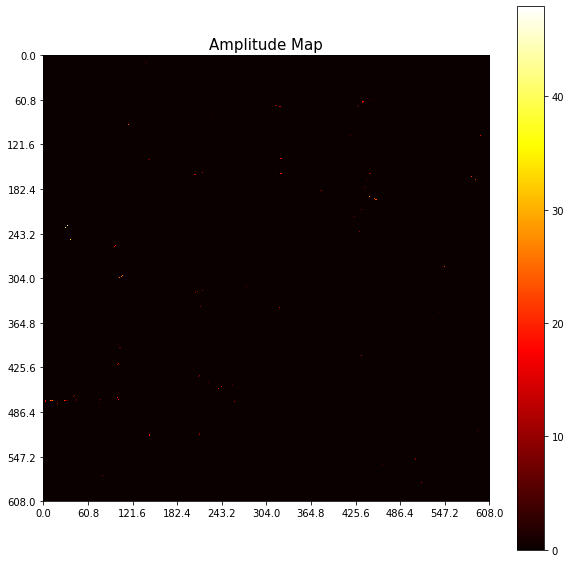

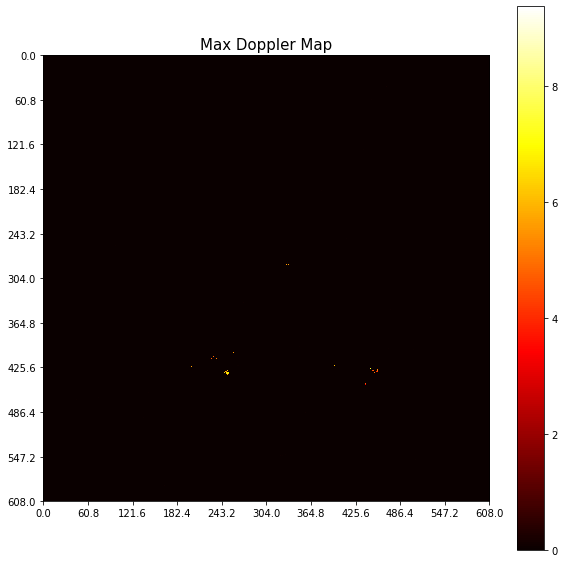

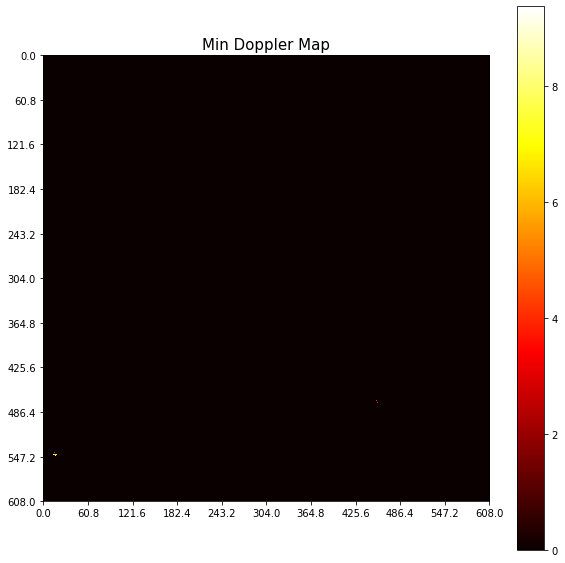

In [13]:
# extract a frame, i.e., 4 continuous scenes from the start time, for DBSCAN
path_to_dataset = "../RS_data_sample"
# Define the *.json file from which data should be loaded
filename = path.join(path_to_dataset, "test_small", "sequence_5", "scenes.json")
sequence = Sequence.from_json(filename)
timestamps = get_timestamps(sequence)
cur_idx = 1647
num_future_frames = 27

radar_data = get_frames(sequence, cur_idx, timestamps, n_next_frames=num_future_frames)
radar_data = clip(radar_data)
map = GridMap(radar_data, num_cell=608)
map.get_max_amplitude_map()
map.get_Doppler_map(mode=True, skew=True) #'max'
map.get_Doppler_map(mode=False, skew=True) #'min'
map.show_heatmap('amp')
map.show_heatmap('max', False)
map.show_heatmap('min', False)

## Test blurry filter

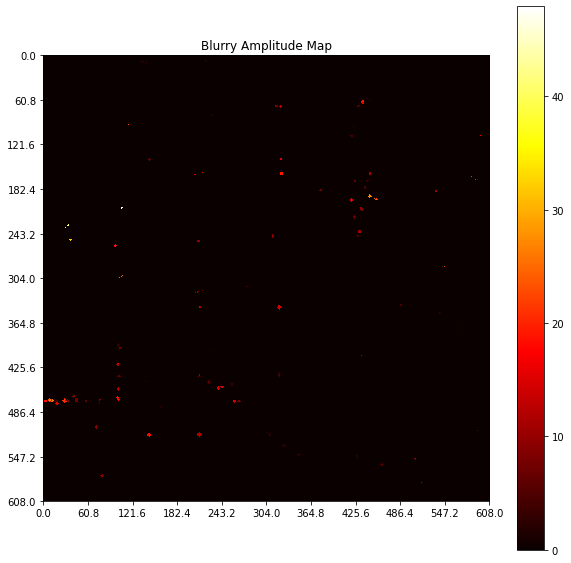

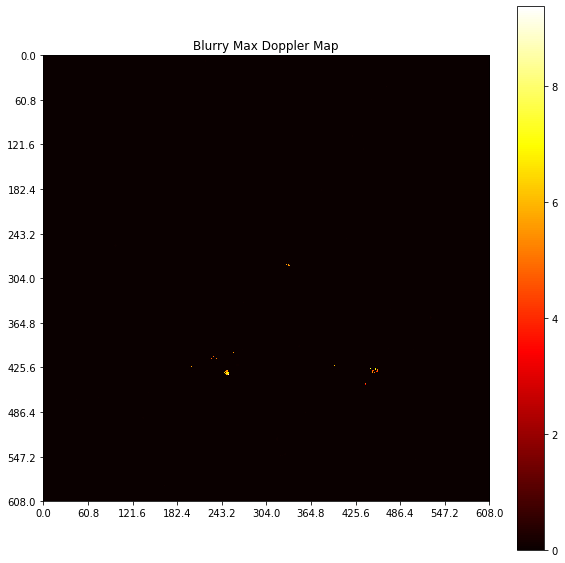

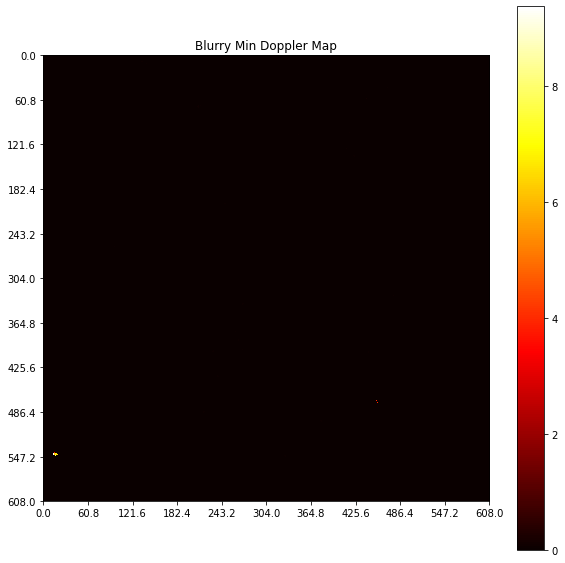

7693.922
152.19080918644178


In [14]:
map.filter_blurry()
map.show_heatmap('amp', blury=True)
map.show_heatmap('max', True)
map.show_heatmap('min', True)

print(sum(-map.amp_map + map.blurry_amp_map))
print(sum(-map.max_doppler_map + map.blurry_max_doppler_map))

In [15]:
image1 = stack((map.amp_map, 
                        map.max_doppler_map, map.min_doppler_map), axis=2)  # different from grid_dataset.py!!!
map_list = [map.amp_map, 
                        map.max_doppler_map, map.min_doppler_map]
# image2 = array([map.amp_map, 
#                        map.max_doppler_map, map.min_doppler_map], dtype=float32) #.reshape((160, 160, 3))

print(image1.shape)
#print(image2.shape)

(608, 608, 3)


load model and predict

In [16]:
model_path = "config/yolov3.cfg"
weights_path = "../yolo/checkpoints/500ms/yolov3_ckpt_50.pth"
model = load_model(model_path, weights_path).float()

In [17]:
image1 = image1.astype(float32)

detections1 = detect_image(model, image1, img_size=608, conf_thres=0.10, nms_thres=0.6) #
# print(detections1.shape)
# print(detections1)

## Visualize output and ground truth in ego-vehicle coordinate


(5,)
(5,)
(5,)
(5,)
(5,)


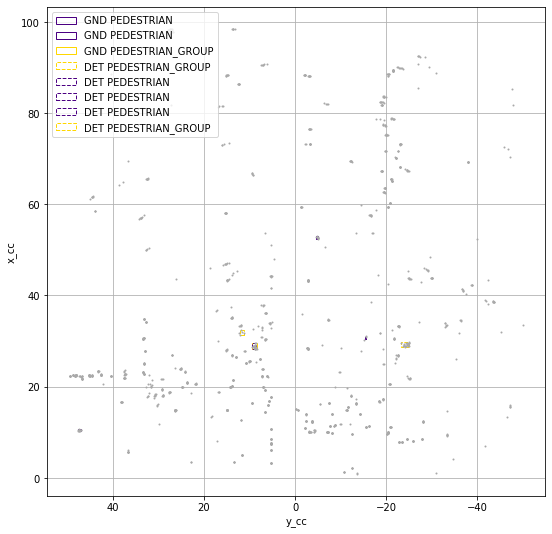

In [18]:
point_cloud = array([radar_data['x_cc'], radar_data['y_cc']])
# detection bboxes
boxes = detections1[:, [0, 1, 2, 3, 5]]
tran_boxes = reverse_transfer(boxes)
#print(tran_boxes.shape)
# gnd bboxes
aligned_boxes1 = get_AABB_snippet(radar_data)
# print(aligned_boxes1.shape)
# visualize the frame
visualize_AABB_cloud(point_cloud, aligned_boxes1, tran_boxes)
plt.grid()
plt.show() 

## Visualize output and ground truth im grid mappings

[[ 16.6714563  544.54163513   4.03044922   3.18805481]
 [333.34215668 287.52319397   3.15748596   2.83865845]
 [249.47062332 432.41467865   6.59581451   8.23358459]]
[[445.91068 427.192   455.517   433.41238]
 [246.8853  428.53308 252.52205 436.58966]
 [331.4469  286.28998 334.52896 288.3946 ]
 [396.6872  418.52548 398.96567 423.08694]
 [230.05847 411.15533 235.37694 417.1983 ]]


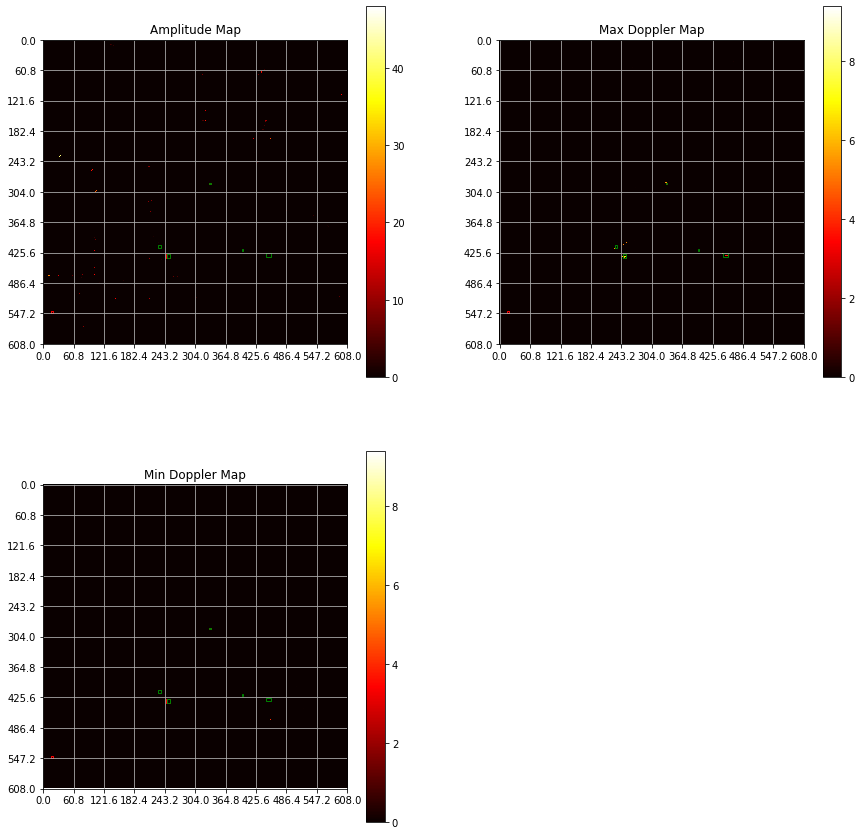

In [19]:
pixel_truth = coor_transfer(array(aligned_boxes1)) * 608
show_heatmap_boxes(map_list, detections1[:, 0:4], pixel_truth[:, 2:6])
print(pixel_truth[:, 2:6])
print(detections1[:, 0:4])